# Vehicle Detection
The goal of this project is to build a pipeline that detects vehicles in a video (to simulate detecting vehicles while on the road).

A classifier will be trained using the following features:
* Histogram of gradients
* Color histogram
* Spatial binning

An image is then searched using sliding windows.  The features of each window are extracted and a prediction is made.  A prediction is made using the previous model.

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

test_image_file_names = glob.glob('./test_images/test*.jpg')
num_images = len(test_image_file_names)

In [2]:
images = []
for idx, test_image_file_name in enumerate(test_image_file_names):
    image = mpimg.imread(test_image_file_name)
    images.append(image)
num_channels = images[0].shape[2]

num_orientations = 9
pixels_per_cell = 8
cells_per_block = 2

## Extract HOG features of each image
The histogram of gradients is extracted from each image.  The image is first grayscaled then run through scikit-image's [hog](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog) function.

The histogram of gradients acts as a "fingerprint" to the image. Images with cars will share a similar fingerprint.

In [3]:
from skimage.feature import hog

def extract_hog_features(img, num_orients, pixels_per_cell, cells_per_block, channel=0, return_hog_img=True, return_feature_vec=True, image_size=(64, 64)):
    image_copy = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    image_copy = cv2.resize(image_copy, image_size)
    return hog(image_copy[:, :, channel], orientations=num_orients, pixels_per_cell=(pixels_per_cell, pixels_per_cell), cells_per_block=(cells_per_block, cells_per_block), block_norm='L2', visualise=return_hog_img, feature_vector=return_feature_vec)

# Color Histogram Features

In [4]:
def get_color_histograms(img):
    histograms = []
    for channel_idx in range(num_channels):
        channel = img[:, :, channel_idx]
        channel_histogram = np.histogram(channel, bins=32, range=(0, 256))
        histograms.append(channel_histogram)
    return histograms


def extract_color_histogram_features(img):
    histogram_data = get_color_histograms(img)
    feature_vector = []
    for channel_idx in range(img.shape[2]):
        histogram = histogram_data[channel_idx][0]
        feature_vector.append(histogram)
    feature_vector = np.concatenate(feature_vector)
    return feature_vector

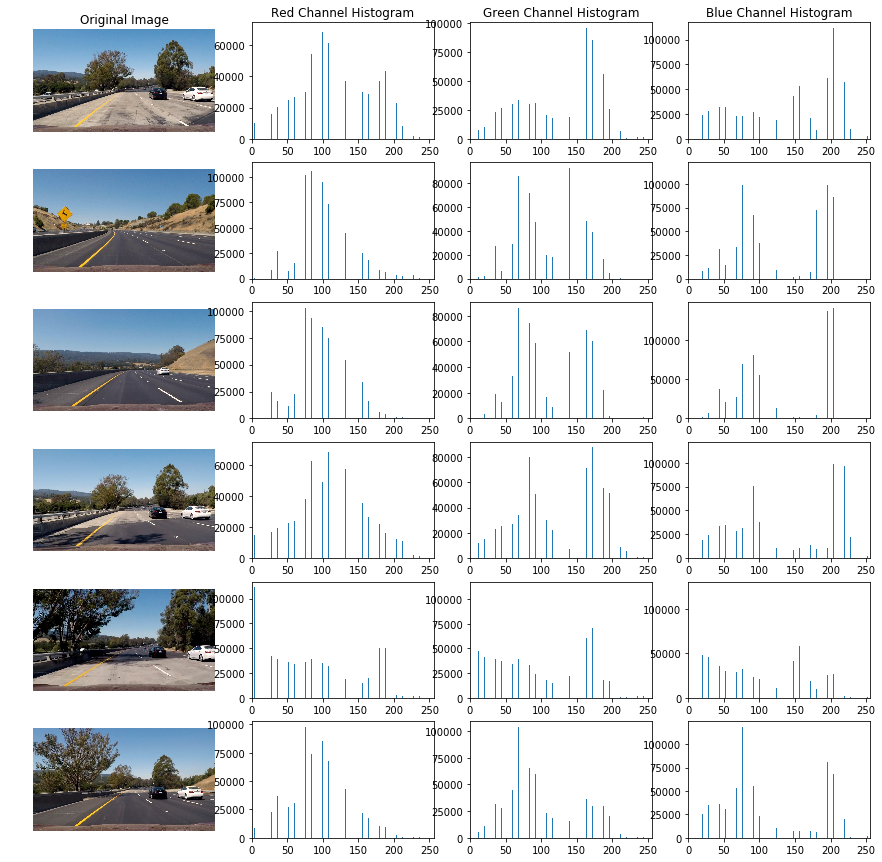

In [5]:
fig, axarr = plt.subplots(num_images, num_channels+1, figsize=(15, 15))
axarr[0, 0].set_title('Original Image')
axarr[0, 1].set_title('Red Channel Histogram')
axarr[0, 2].set_title('Green Channel Histogram')
axarr[0, 3].set_title('Blue Channel Histogram')

color_histogram_feature_vector = []
for idx, image in enumerate(images):
    histogram_data = get_color_histograms(image) # get color histograms used to plot data

    R_histogram = histogram_data[0][0]
    G_histogram = histogram_data[1][0]
    B_histogram = histogram_data[2][0]
    bin_edges = histogram_data[0][1]
    bin_centers = (bin_edges[1:] + bin_edges[0:-1])/2

    color_histogram_feature_vector.append(np.concatenate((R_histogram, G_histogram, B_histogram)))

    # Plot Data
    bin_centers = (bin_edges[1:] + bin_edges[0:-1])/2
    axarr[idx, 0].imshow(image)
    axarr[idx, 0].axis('off')
    
    for j, histogram_datum in enumerate(histogram_data):
        histogram = histogram_datum[0]
        axarr[idx, j+1].bar(bin_centers, histogram)
        axarr[idx, j+1].set_xlim(0, 256)
plt.show()

In [6]:
def spatial_bin_features(img, size=(64, 64)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Train Classifier

In [7]:
def extract_all_features(img):
    hog_features = []
    for channel_idx in range(img.shape[2]):
        hog_features.append(extract_hog_features(img, num_orientations, pixels_per_cell, cells_per_block, channel=channel_idx, return_hog_img=False, return_feature_vec=True))
    hog_features = np.ravel(hog_features)
    color_hist_features = extract_color_histogram_features(img)
    bin_features = spatial_bin_features(img)
    features = np.concatenate((hog_features, color_hist_features, bin_features))
    return features

In [8]:
car_paths = glob.glob('./vehicles/**/*.png')
notcar_paths = glob.glob('./non-vehicles/**/*.png')
print("There are {} car images.".format(len(car_paths)))
print("There are {} non-car images".format(len(notcar_paths)))

features = []
for car_path in car_paths:
    car_img = mpimg.imread(car_path)
    single_car_features = extract_all_features(car_img)
    features.append(single_car_features)

for notcar_path in notcar_paths:
    notcar_img = mpimg.imread(notcar_path)
    single_notcar_features = extract_all_features(notcar_img)
    features.append(single_notcar_features)
print("Each image has {} features".format(len(features[0])))

There are 8791 car images.
There are 8966 non-car images
Each image has 17676 features


In [9]:
from sklearn.preprocessing import StandardScaler

features = np.array(features)

X_scaler = StandardScaler().fit(features)
scaled_X = X_scaler.transform(features)

y = np.hstack((np.ones(len(car_paths)), np.zeros(len(notcar_paths))))

In [10]:
# Save X_scaler, scaled_X and y
from sklearn.externals import joblib
joblib.dump(X_scaler, 'X_scaler.pkl')
joblib.dump(scaled_X, 'scaled_X.pkl')
joblib.dump(y, 'y.pkl')

['y.pkl']

In [11]:
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time

if 'scaled_X' not in locals():
    scaled_X = joblib.load('scaled_X.pkl')
if 'y' not in locals():
    y = joblib.load('y.pkl')

shuffle(scaled_X, y)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
del scaled_X, y

svc = LinearSVC(C=0.01)

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

91.37 seconds to train SVC.
Test Accuracy of SVC =  0.9893


In [12]:
# Save svc
joblib.dump(svc, 'svc.pkl')

['svc.pkl']

In [13]:
# Mock predictions
n_predict = 20
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

My SVC predicts:  [ 1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  1.  0.  1.  0.
  0.  1.]
For these 20 labels:  [ 1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  1.  0.  1.  0.
  0.  1.]


# Sliding Windows
Each image (or video frame) is scanned for vehicles, window by window.

In [14]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

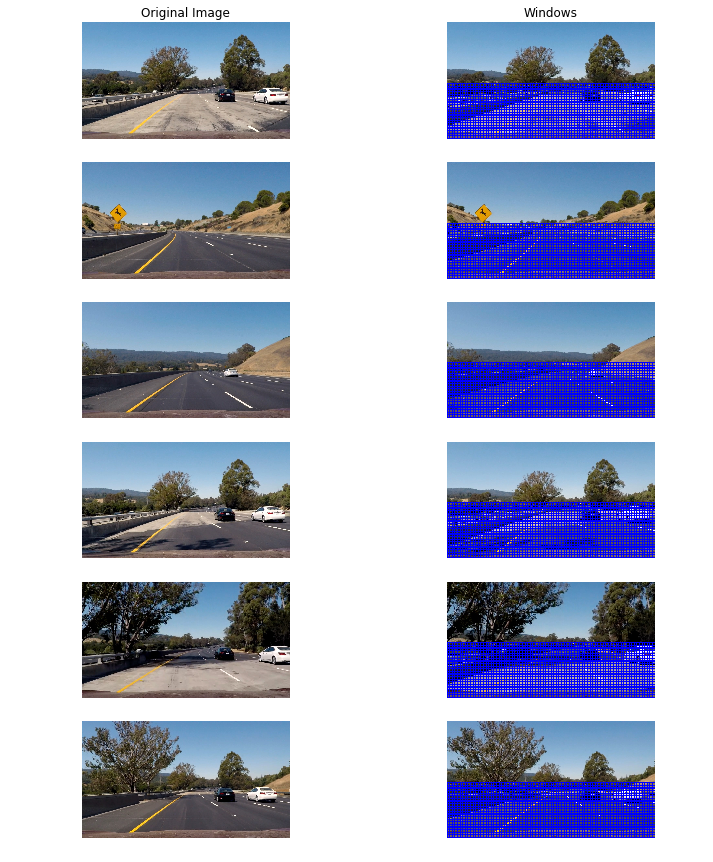

In [15]:
fig, axarr = plt.subplots(num_images, 2, figsize=(12, 15), sharey=True)
axarr[0, 0].set_title('Original Image')
axarr[0, 1].set_title('Windows')

window_size = (64, 64)
y_start_stop = [380, None]
# Show working sliding windows function
for idx, image in enumerate(images):
    windows = slide_window(image, y_start_stop=y_start_stop, xy_window=window_size)
    windows_img = draw_boxes(image, windows)
    axarr[idx, 0].imshow(image)
    axarr[idx, 1].imshow(windows_img)
    axarr[idx, 0].axis('off')
    axarr[idx, 1].axis('off')
plt.show()

# Search Windows
Search each window for a car.  Draw a blue box around areas with cars.  To do this, a heatmap is created where duplicate detections are found.  A bounding box is then drawn around the appropriate coordinates of the heat map.

In [83]:
from sklearn.externals import joblib
if 'scaled_X' not in locals():
    scaled_X = joblib.load('scaled_X.pkl')
if 'svc' not in locals():
    svc = joblib.load('svc.pkl')

In [84]:
from scipy.ndimage.measurements import label

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, window_size):
    window_height = window_size[1]
    halt_factor = 7
    # Scale img (trained on .pngs that were 0 to 1)
    img = img.astype(np.float32)/255
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        window_y = window[1][1]
        if window_y / window_height >= halt_factor:
            continue
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], window_size)
        #4) Extract features for that window using single_img_features()
        features = extract_all_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) and high confidence, save the window
        if prediction == 1 and clf.decision_function(test_features) > 0.2:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img


def process_image(image, is_still_image=False):
    detected_windows = []
    window_sizes = [(80, 80), (144, 144), (256, 256)]

    for window_size in window_sizes:
        windows = slide_window(image, y_start_stop=y_start_stop, xy_window=window_size)
        detected_windows.append(search_windows(image, windows, svc, X_scaler, window_size))
    detected_windows = sum(detected_windows, [])

    # Create heat map
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, detected_windows)

    if not is_still_image:
        # For video, store old heatmaps and threshold based off them
        heatmaps.append(heat)
        combined = np.sum(heatmaps, axis = 0)
        heat = apply_threshold(combined, len(heatmaps)-1)
    else:
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, 1)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    drawn_img = draw_labeled_bboxes(np.copy(image), labels)

    return drawn_img

It took an average of 2.99 seconds to process each image


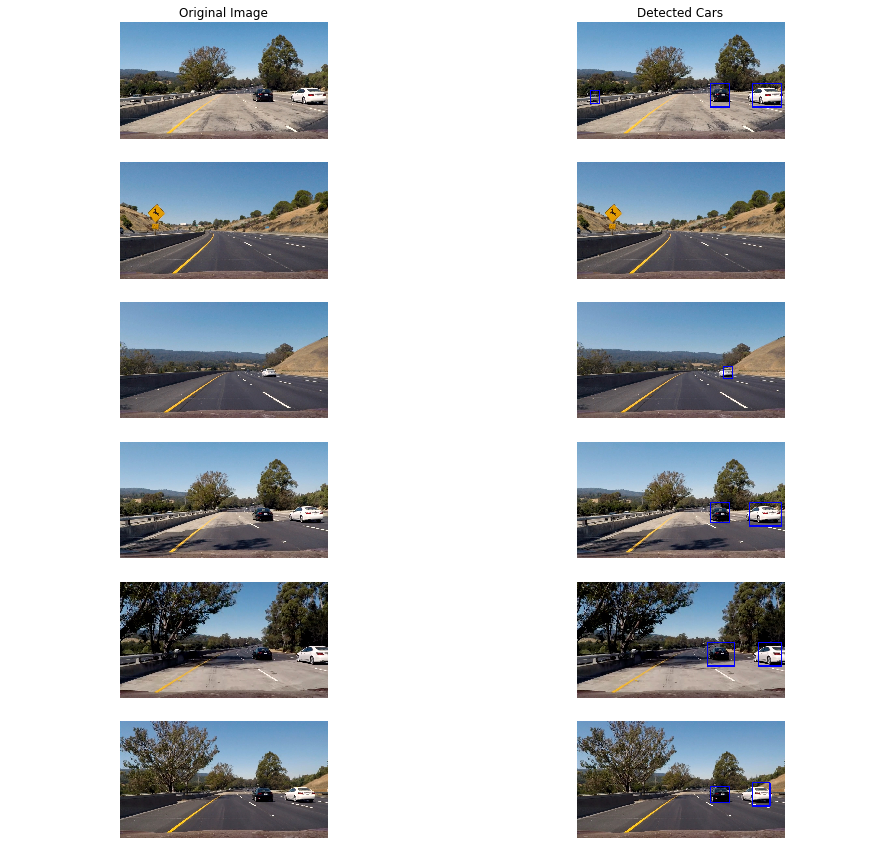

In [85]:
import time

if 'X_scaler' not in locals():
    X_scaler = joblib.load('X_scaler.pkl')
if 'svc' not in locals():
    svc = joblib.load('svc.pkl')

fig, axarr = plt.subplots(num_images, 2, figsize=(15, 15), sharey=True)
axarr[0, 0].set_title('Original Image')
axarr[0, 1].set_title('Detected Cars')

total_time = 0
for idx, image in enumerate(images):
    t1 = time.time()
    drawn_img = process_image(image, is_still_image=True)
    t2 = time.time()
    total_time += (t2-t1)
    
    axarr[idx, 0].imshow(image)
    axarr[idx, 1].imshow(drawn_img)
    axarr[idx, 0].axis('off')
    axarr[idx, 1].axis('off')
print("It took an average of {} seconds to process each image".format(round(total_time/len(images), 2)))
plt.show()

# Process Video

In [86]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

In [ ]:
from collections import deque
heatmaps = deque(maxlen=10)
output_file_name = 'vehicle_detection.mp4'
clip1 = VideoFileClip('project_video.mp4')
lane_line_clip = clip1.fl_image(process_image)
%time lane_line_clip.write_videofile(output_file_name, audio=False)